In [1]:
import sys, os
sys.path.insert(0, '../')
sys.path.insert(0, '../python_src/')

import numpy as np
import scipy as sp
import pandas as pd
import numpy.random as rand
import scipy.optimize as spo
import cPickle as pickle
import portalocker
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns
import shutil, shelve
import tarfile
import time
import itertools as it
import matplotlib.lines as mlines
import matplotlib as mpl

import mech_network_solver as mns
import network
import tuning_algs as talgs
import network_plot as nplot

mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set(color_codes=True)
sns.set_context('talk', font_scale=1.75)
# sns.set_palette("hls", 9)
sns.set_palette("Blues", 6)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})

Loading Mechanical Network Deformation Solver Module


In [ ]:
directory = "/data1/home/rocks/data/sat_transition/tune_disc_local_2D_23/"


t0 = time.time()

# os.remove(directory+"tune_analysis.pkl")

db = shelve.open(directory+"tune_db.bin", flag='r')    

files = set(db.keys())

tol = 1e-10

df = pd.DataFrame(columns=['NN', 'NTS', 'irec', 'itarget', 'network_success', 'target_success', 'dist'], dtype=float)

s_list = []

print len(files)

for i, fn in enumerate(files):
    if i % 1000 == 0:
        print i
    
    data = db[fn]
    nw_label = data['network_label']
        
    with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

        nw_data = pickle.load(pkl_file)
        net = nw_data['network']
        
        edgei = net.edgei
        edgej = net.edgej
        
        adj = network.getLineGraph(net.NN, net.NE, edgei, edgej)
        
        source = data['istrain_edges'][0][0]
          
        dists = network.getGraphDistances(adj, source)
            
        targets = data['ostrain_edges'][0]
                    
        target_dists =  dists[targets]
        
        
        NN = data['NN_init']
        NTS = data['NTS']
        irec = data['irec']
        obj_func = data['obj_func']
                
        network_success = obj_func < tol
                
        res = data['obj_res']
        
        for itarget in range(NTS):
            target_success = np.abs(res[itarget]) < tol
                        
            s_list.append(pd.Series({'NN': NN, 'NTS': NTS, 'irec': irec, 'itarget': itarget, 
                                    'network_success': network_success, 'target_success': target_success,
                                    'dist': target_dists[itarget]}))
            
    
df_add = pd.DataFrame(s_list, columns=['NN', 'NTS', 'irec', 'itarget', 
                                       'network_success', 'target_success', 'dist'])
      
df = pd.concat([df, df_add])    

print "Complete"

49522
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000


In [50]:
pd.options.display.max_rows = 999


def wilson_up(p, n):
    z = 1.0
    return 1.0 / (1.0 + z**2/n) * (p + 0.5*z**2 / n + z*np.sqrt(1.0/n * p * (1.0 - p) + 0.25*z**2/n**2)) - p

def wilson_low(p, n):
    z = 1.0
    return p - 1.0 / (1.0 + z**2/n) * (p + 0.5*z**2 / n - z*np.sqrt(1.0/n * p * (1.0 - p) + 0.25*z**2/n**2))


print  df[df.network_success==0.0].groupby(['NN', 'dist']).size()

df_agg = df.groupby(['NN', 'NTS', 'network_success', 'dist']).agg({'target_success': np.mean})

df_agg['count'] = df.groupby(['NN', 'NTS', 'network_success', 'dist']).size()

df_agg = df_agg.reset_index()

# print df_agg[df_agg.network_success==0.0]


df_agg['err_up'] = wilson_up(df_agg['target_success'], df_agg['count'])
df_agg['err_low'] = wilson_low(df_agg['target_success'], df_agg['count'])

NN     dist 
8.0    1.0      12329
       2.0      12755
       3.0       3225
       4.0        452
       5.0         36
       6.0          1
16.0   1.0       7030
       2.0      10565
       3.0       8789
       4.0       4390
       5.0       1814
       6.0        797
       7.0        286
       8.0        105
       9.0         34
       10.0         5
32.0   1.0      13715
       2.0      21099
       3.0      25042
       4.0      23930
       5.0      18250
       6.0      12014
       7.0       7464
       8.0       4578
       9.0       2776
       10.0      1695
       11.0      1028
       12.0       592
       13.0       339
       14.0       140
       15.0        68
       16.0        34
       17.0        10
       18.0         3
64.0   1.0       6780
       2.0      10182
       3.0      12374
       4.0      14148
       5.0      15690
       6.0      15009
       7.0      13168
       8.0      10449
       9.0       7951
       10.0      5922
       11.0      44

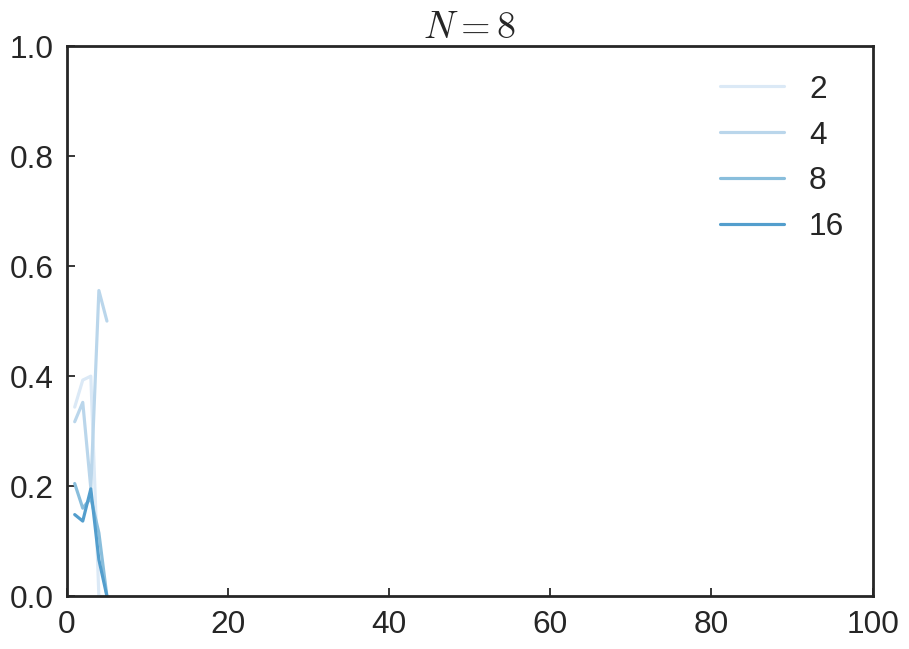

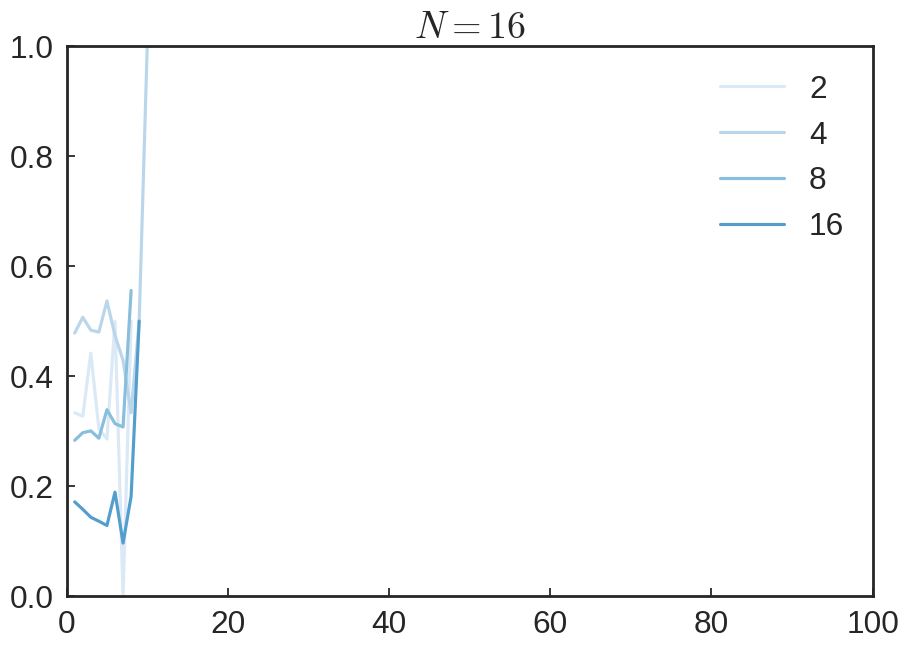

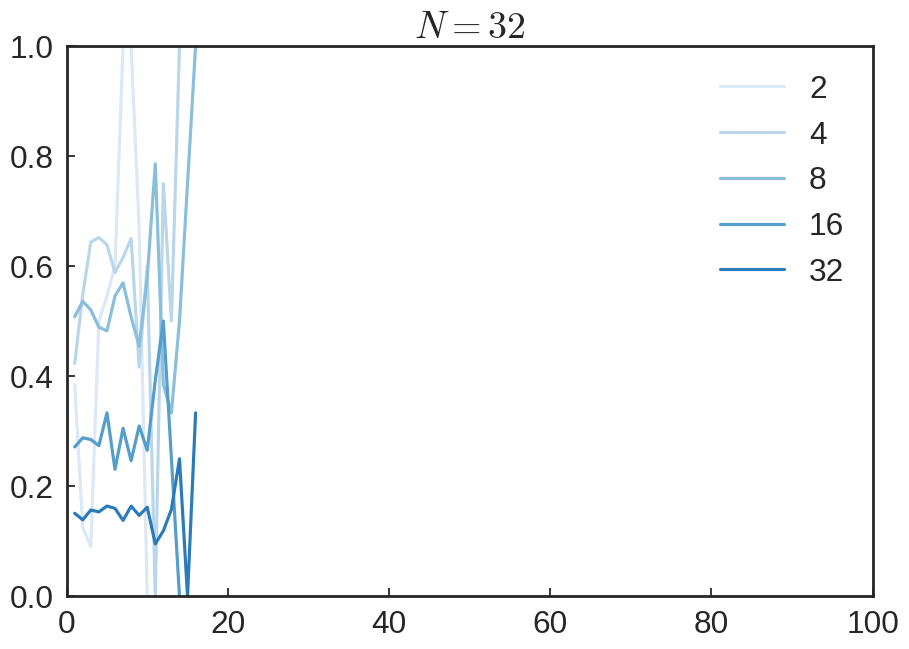

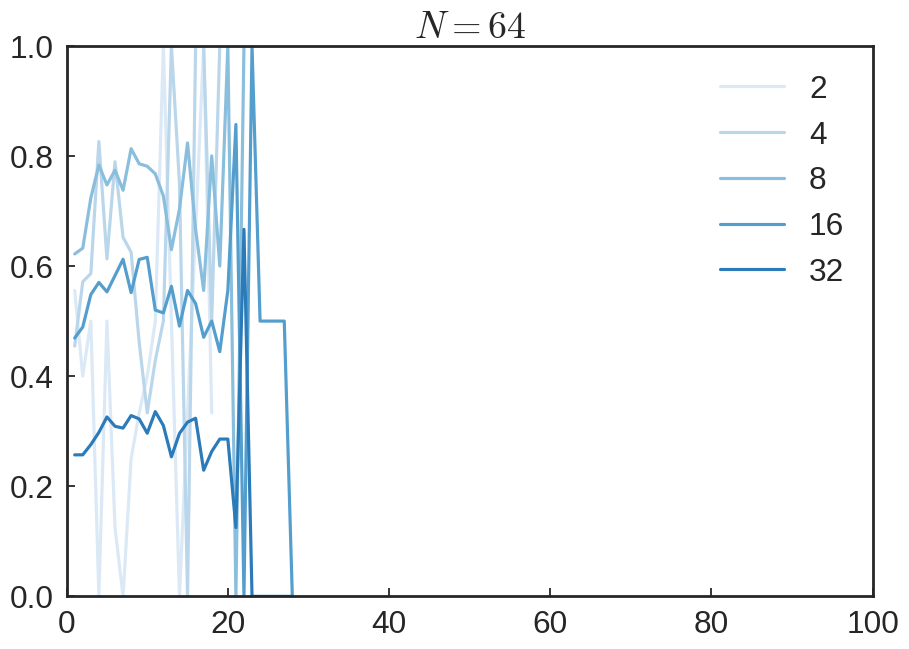

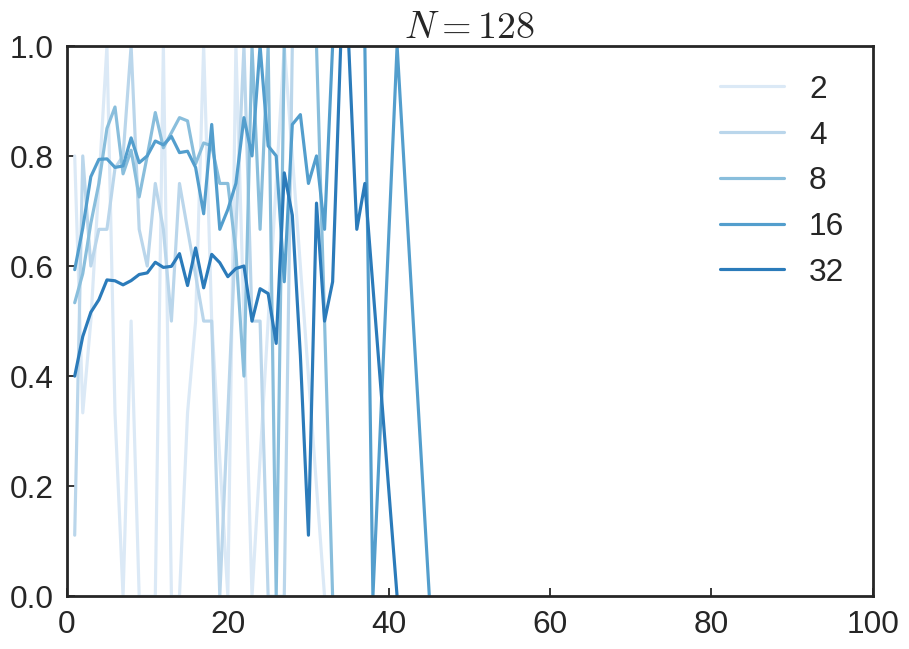

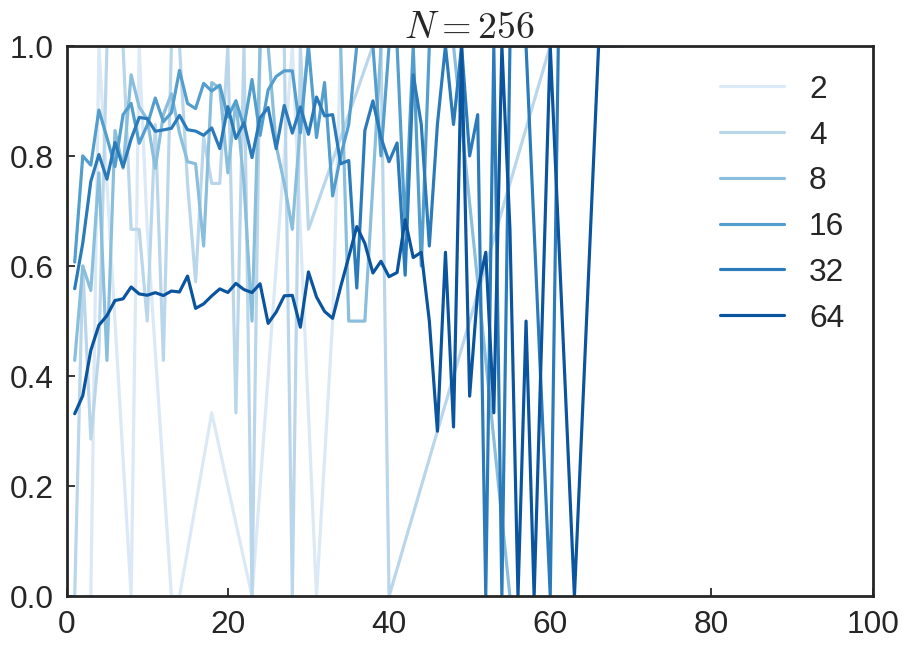

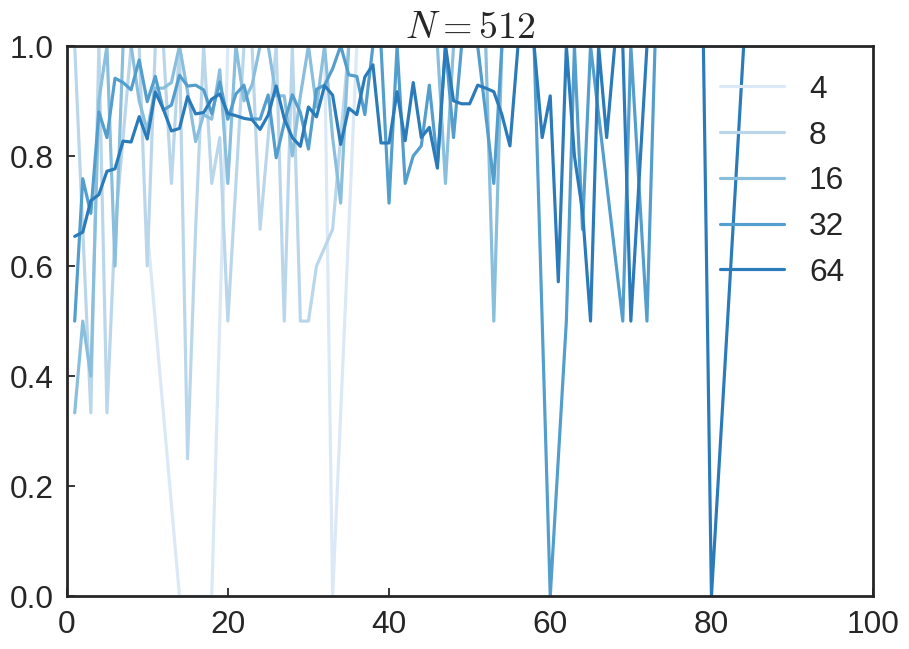

In [60]:


for NN, group0 in df_agg[(df_agg.network_success==0.0)].groupby('NN'):
    palette = it.cycle(sns.color_palette())
    
    fig, ax = plt.subplots(1,1)
        
    for NTS, group1 in group0.groupby('NTS'): 
        if NTS != 2 and NTS != 4 and NTS != 8 and NTS != 16 and NTS != 32 and NTS != 64:
            continue
        
        dist = np.array(group1['dist'])
        fsat = np.array(group1['target_success'])
        fsat_low = np.array(group1['err_low'])
        fsat_up = np.array(group1['err_up'])
        
        color = next(palette)
        
#         ax.errorbar(dist, fsat, 
#                     yerr=[fsat_low, fsat_up], fmt=".-", label="{:}".format(int(NTS)), 
#                      color=color)
        
        ax.plot(dist, fsat, '-', color=color, label="{:}".format(int(NTS)))
        
    ax.legend()
    
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 100)
     
    ax.set_title("$N={0:d}$".format(int(NN)))
    plt.show()
        